In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
import pickle

In [2]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications import Xception
from keras.applications import VGG16 ,VGG19
from keras.applications import MobileNetV3Small, MobileNetV3Large
from keras.applications import DenseNet201
from keras.applications import EfficientNetB7
from keras.applications import EfficientNetV2S , EfficientNetV2L


In [3]:
from keras.applications import ResNet152V2

In [8]:
# ResNet 152V2
# Binary Classification


img_height ,img_width = (224,224)
batch_size = 32

train_data_dir = "C:/Users/ASUS/Gray_Training/Binary Classification/Training"
valid_data_dir = "C:/Users/ASUS/Gray_Training/Binary Classification/validation"
test_data_dir = "C:/Users/ASUS/Gray_Training/Binary Classification/Testing"

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    validation_split = 0)

train_generator = train_datagen.flow_from_directory(
     train_data_dir,
     target_size = (img_height,img_width),
     batch_size = batch_size,
     class_mode = 'categorical',
     subset = 'training')

#valid_generator(train_datagen.flow_from_directory(
     #valid_data_dir,
     #target_size = (img_height,img_width),
     #batch_size = batch_size,
     #class_mode = 'categorical',
     #subset = 'validation')
#)

Found 925 images belonging to 2 classes.


In [18]:
test_datagen = ImageDataGenerator(rescale = 1/255)

test_set = test_datagen.flow_from_directory(
            test_data_dir,
            target_size = (img_height,img_width),
            batch_size = 1,
            class_mode = 'categorical')

Found 121 images belonging to 2 classes.


In [9]:
valid_datagen = ImageDataGenerator(rescale = 1/255)

valid_set = valid_datagen.flow_from_directory(
            valid_data_dir,
            target_size = (img_height,img_width),
            batch_size = 1,
            class_mode = 'categorical')

Found 154 images belonging to 2 classes.


In [7]:
#test_generator = train_datagen.flow_from_directory(
    #test_data_dir,
    #target_size = (img_height,img_width),
    #batch_size = 1,
    #class_mode = 'categorical',
    #subset = 'training')


In [10]:
X, y = test_set.next()
X.shape

(12, 224, 224, 3)

In [11]:
Res152V2_arch = ResNet152V2(input_shape = (img_height ,img_width , 3) , weights = 'imagenet', include_top = False)

In [12]:
base_model = ResNet152V2(include_top = False, weights = 'imagenet')
X = base_model.output
X = GlobalAveragePooling2D()(X)
X = Dense(1024, activation = 'relu')(X)
predictions = Dense(train_generator.num_classes , activation = 'softmax')(X)
model = Model(inputs = base_model.input , outputs = predictions)


for layer in base_model.layers:
    layer.trainable = False
    
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])  
r = model.fit(train_generator, validation_data = valid_set, epochs = 5)

Epoch 1/5
29/29 [==============================] - 309s 10s/step - loss: 0.3260 - accuracy: 0.8930 - val_loss: 0.2559 - val_accuracy: 0.9156
Epoch 2/5
29/29 [==============================] - 287s 10s/step - loss: 0.0619 - accuracy: 0.9784 - val_loss: 0.1257 - val_accuracy: 0.9610
Epoch 3/5
29/29 [==============================] - 264s 9s/step - loss: 0.0438 - accuracy: 0.9838 - val_loss: 0.1423 - val_accuracy: 0.9416
Epoch 4/5
29/29 [==============================] - 146s 5s/step - loss: 0.0315 - accuracy: 0.9870 - val_loss: 0.1243 - val_accuracy: 0.9610
Epoch 5/5
29/29 [==============================] - 157s 5s/step - loss: 0.0329 - accuracy: 0.9859 - val_loss: 0.1095 - val_accuracy: 0.9610


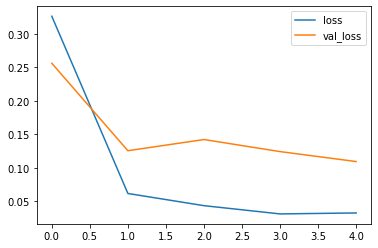

In [21]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')

plt.legend()

In [22]:
model.save('C:/Users/ASUS/Gray_Training/Binary Classification/first_saved_model_152GH.h5')

In [23]:
test_loss, test_acc = model.evaluate(test_set)
print('\nTest Accuracy:' , test_acc)

121/121 [==============================] - 61s 437ms/step - loss: 0.0631 - accuracy: 0.9752

Test Accuracy: 0.9752066135406494


1/1 [==============================] - 0s 192ms/step


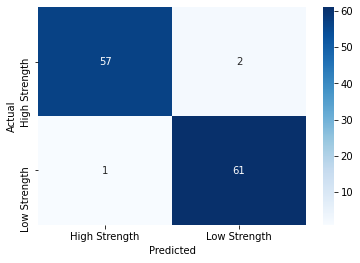

test accuracy : 97.52066115702479


In [24]:
import pandas as pd
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model('C:/Users/ASUS/Gray_Training/Binary Classification/first_saved_model_152GH.h5')
filenames  = test_set.filenames
nb_samples = len(test_set)
y_prob = []
y_act = []

test_set.reset()
for _ in range(nb_samples):
    X_test, y_test = test_set.next()
    y_prob.append(model.predict(X_test))
    y_act.append(y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob] 
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T, columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames = ['Actual'], colnames = ['Predicted'])
sns.heatmap(confusion_matrix , cmap = 'Blues' , annot = True , fmt = 'd')
plt.show()
print('test accuracy : {}'. format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))